In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os

data = pd.read_csv('hotel_bookings.csv')

In [2]:
# Train-test split
from sklearn.model_selection import train_test_split
y = (data['is_canceled'] == 1)
X = data.drop('is_canceled',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=42)

In [3]:
# Make a function to pre-process the data
# Surprising features that didn't help:
#     assigned_room_type, one-hot-encoded into categories.
#     is_repeated_guest, since relevant past info is already included in previous_cancellations

def preprocess(X):
    # Remove unused variables
    drop_vars = ['arrival_date_year','arrival_date_day_of_month','arrival_date_month','previous_bookings_not_canceled',
                 'agent','company','days_in_waiting_list','children','babies','assigned_room_type',
                'country','distribution_channel','reserved_room_type','meal','is_repeated_guest',
                 'deposit_type','reservation_status','reservation_status_date']
    for v in drop_vars:
        if v in X.keys():
            X = X.drop(v,axis=1)
    
    # Replace some NaNs
    if 'children' in X.keys():
        children = X['children']
        children[np.isnan(children)] = 0
        X.update(children)
    
    # Put market_segment into groups:
    # Groups, Online TA + Offline TA/TO, Other.
    # "Complementary" has a lot of info but it's equivalent to adr = 0 so no need to include
    ms_groups = X['market_segment'] == 'Groups'
    ms_ta = (X['market_segment'] == 'Online TA') | (X['market_segment'] == 'Offline TA/TO')
    ms_other = ~(ms_groups | ms_ta)
    X.insert(5,'ms_groups',ms_groups)
    X.insert(5,'ms_ta',ms_ta)
    X.insert(5,'ms_other',ms_other)
    X = X.drop('market_segment',axis=1)
    
    # One-Hot-Encode customer type
    ct_contract = X['customer_type'] == 'Contract'
    ct_group = X['customer_type'] == 'Group'
    ct_transient = X['customer_type'] == 'Transient'
    ct_transient_party = X['customer_type'] == 'Transient-Party'
    X.insert(5,'ct_contract',ct_contract)
    X.insert(5,'ct_group',ct_group)
    X.insert(5,'ct_transient',ct_transient)
    X.insert(5,'ct_transient_party',ct_transient_party)
    X = X.drop('customer_type',axis=1)
    
    # Fix outliers in adr
    X.update(X['adr'].apply(lambda x: min(500,x)))
    X.update(X['adr'].apply(lambda x: max(0,x)))
    
    # Fix outliers in adults
    X.update(X['adults'].apply(lambda x: min(5,x)))
    
    # Include total length of booking instead of week nights vs weekend nights
    num_nights = X['stays_in_weekend_nights'] | X['stays_in_week_nights']
    X = X.drop(['stays_in_weekend_nights','stays_in_week_nights'],axis=1)
    X.insert(1,'num_nights',num_nights)

    # Hotel can be transformed to a binary
    if 'hotel' in X.keys():
        is_resort = (X['hotel'] == 'Resort Hotel')
        X.insert(1,'is_resort',is_resort)
        X = X.drop(['hotel'],axis=1)
    
    return X

X_train = preprocess(X_train)
X_test = preprocess(X_test)
data_plot = preprocess(data)

In [4]:
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,min_samples_leaf=10)
model.fit(X_train,y_train);

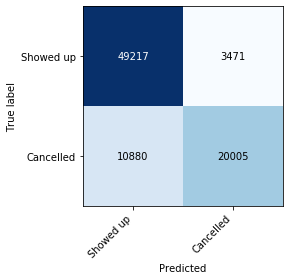

Accuracy score (training) 0.8282818613667093
F1 score (training): 0.7360055922444398
Recall (training): 0.6477254330581188
Precision (training): 0.852146873402624


In [5]:
# Check accuracy and confusion matrix
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,accuracy_score
from hotel_modules import plot_confusion_matrix
y_train_pred = cross_val_predict(model,X_train,y_train,cv=6)
conf_mx = confusion_matrix(y_train,y_train_pred)
plot_confusion_matrix(conf_mx,cats = ['Showed up','Cancelled'])

f1 = f1_score(y_train,y_train_pred)
print('Accuracy score (training)',accuracy_score(y_train,y_train_pred))
print('F1 score (training):',f1)
print('Recall (training):',recall_score(y_train,y_train_pred))
print('Precision (training):',precision_score(y_train,y_train_pred))

In [6]:
# Look at feature importances
for ix,k in enumerate(X_train.keys()):
    print(k,model.feature_importances_[ix])

is_resort 0.01520762774618451
num_nights 0.03298310753601156
lead_time 0.2233097149319071
arrival_date_week_number 0.07173897803719538
ct_transient_party 0.04087771919052158
ct_transient 0.05913183139840903
ct_group 0.00025065678459740173
ct_contract 0.005380444121807026
ms_other 0.03370601075054224
ms_ta 0.02323645608584115
ms_groups 0.051355000266282314
adults 0.014054057639056776
previous_cancellations 0.10190398966906594
booking_changes 0.04046711141434378
adr 0.11589311661185256
required_car_parking_spaces 0.04400190598622978
total_of_special_requests 0.1265022718301519


In [8]:
# SAVE THIS FOR THE END!
# Accuracy and confusion matrix
# from sklearn.model_selection import cross_val_score,cross_val_predict
# from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,accuracy_score
# from hotel_modules import plot_confusion_matrix
# y_test_pred = cross_val_predict(model,X_test,y_test,cv=6)
# conf_mx = confusion_matrix(y_test,y_test_pred)
# plot_confusion_matrix(conf_mx,cats = ['Showed up','Cancelled'])

# f1 = f1_score(y_test,y_test_pred)
# print('Accuracy score (test)',accuracy_score(y_test,y_test_pred))
# print('F1 score (test):',f1)
# print('Recall (test):',recall_score(y_test,y_test_pred))
# print('Precision (test):',precision_score(y_test,y_test_pred))